In [1]:
import sys
from tqdm import tqdm
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['font.family'] = 'arial'
mpl.rcParams['font.size'] = 14
np.set_printoptions(threshold=sys.maxsize,
                    suppress=True)

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import random_split, Dataset, DataLoader
import torch.optim as optim

torch.manual_seed(114514)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print(torch.__config__.show())
print(f'PyTorch is running on {device}')

PyTorch built with:
  - C++ Version: 199711
  - MSVC 193431937
  - Intel(R) Math Kernel Library Version 2020.0.2 Product Build 20200624 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 2019
  - LAPACK is enabled (usually provided by MKL)
  - CPU capability usage: AVX2
  - CUDA Runtime 11.8
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_80,code=sm_80;-gencode;arch=compute_86,code=sm_86;-gencode;arch=compute_90,code=sm_90;-gencode;arch=compute_37,code=compute_37
  - CuDNN 8.7
  - Magma 2.5.4
  - Build settings: BLAS_INFO=mkl, BUILD_TYPE=Release, CUDA_VERSION=11.8, CUDNN_VERSION=8.7.0, CXX_COMPILER=C:/cb/pytorch_1000000000000/work/tmp_bin/sccache-cl.exe, CXX_FLAGS=/DWIN32 /D_WINDOWS /GR /EH

In [109]:
class GaitDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.shape[0]
    
    def __getitem__(self, idx):
        return self.features[idx, ...], self.labels[idx]

class GaitGRUModel(nn.Module):
    def __init__(self, input_dim: int, hidden_dim: int, layer_dim: int, output_dim: int,
                 reduced_chnl: int, kernel_size: int, stride: int):
        super().__init__()

        # channel weighting layer
        self.channel_weights = nn.Linear(input_dim, reduced_chnl)

        # sequence length reduction layer
        self.seq_reduction_conv = nn.Conv1d(reduced_chnl, reduced_chnl,
                                            kernel_size=kernel_size,
                                            stride=stride,
                                            padding=1)

        self.gru = nn.GRU(reduced_chnl, hidden_dim, layer_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, x: torch.Tensor):
        x = x.permute(0, 2, 1) # permute to [batch, seq_len, num_channels]

        batch_size, seq_len, num_channels = x.shape
        x = x.reshape([batch_size * seq_len, num_channels])
        x = self.channel_weights(x)
        x = x.reshape([batch_size, -1, seq_len])
        x = self.seq_reduction_conv(x)
        x = x.permute(0, 2, 1) # permute back to (batch, seq_len, num_channels) for rnn

        x, _ = self.gru(x)
        x = self.fc(x[:, -1, :])
        out = self.softmax(x)
        return out

# Data load

In [85]:
batch_size = 32

ds = torch.load('dataset/gait_o.pt')

train_size = int(0.8 * len(ds))
test_size = len(ds) - train_size

train_ds, test_ds = random_split(ds, (train_size, test_size))
train_loader, test_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=False), DataLoader(test_ds, batch_size=batch_size, shuffle=False)

# Hyperparameters

In [105]:
input_dim = 8
hidden_dim = 128
layer_dim = 1
output_dim = len(torch.unique(ds.labels)) # Number of classes
dropout_prob = 0

reduced_chnl = 4
kernel_size = 100
stride = 100

num_epochs = 100

# Training

In [110]:
print(ds.features.shape)
print(ds.labels.shape)

torch.Size([263, 8, 1500])
torch.Size([263])


In [111]:
model = GaitGRUModel(input_dim, hidden_dim, layer_dim, output_dim,
                    reduced_chnl, kernel_size, stride).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.002, weight_decay=0.01)

print(model)
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

GaitGRUModel(
  (channel_weights): Linear(in_features=8, out_features=4, bias=True)
  (seq_reduction_conv): Conv1d(4, 4, kernel_size=(100,), stride=(100,), padding=(1,))
  (gru): GRU(4, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4, bias=True)
  (softmax): LogSoftmax(dim=1)
)
53612


In [112]:
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0
    correct_predictions = 0
    total_predictions = 0

    for i, (features, labels) in enumerate(train_loader):
        features, labels = features.to(device).float(), labels.to(device).long()

        # print(features.shape)
        outputs = model(features)
        # print(outputs.shape)

        loss = criterion(outputs, labels.squeeze())
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss = running_loss / len(train_loader)
    train_accuracy = correct_predictions / total_predictions
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Testing phase
    model.eval()
    test_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    
    with torch.no_grad():
        for features, labels in test_loader:
            features, labels = features.to(device).float(), labels.to(device).long()
            outputs = model(features)

            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_predictions += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()
    
    test_loss /= len(test_loader)
    test_accuracy = correct_predictions / total_predictions
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    if (epoch + 1) % 20 == 0:
        print(f'Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, \
            Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

 22%|██▏       | 22/100 [00:00<00:03, 26.00it/s]

Epoch [20/100], Train Loss: 0.3199, Train Accuracy: 0.8524,             Test Loss: 0.3581, Test Accuracy: 0.8302


 46%|████▌     | 46/100 [00:01<00:01, 29.78it/s]

Epoch [40/100], Train Loss: 0.1902, Train Accuracy: 0.9429,             Test Loss: 0.3358, Test Accuracy: 0.9245


 64%|██████▍   | 64/100 [00:02<00:01, 28.43it/s]

Epoch [60/100], Train Loss: 0.0494, Train Accuracy: 0.9857,             Test Loss: 0.1817, Test Accuracy: 0.9245


 83%|████████▎ | 83/100 [00:02<00:00, 30.00it/s]

Epoch [80/100], Train Loss: 0.0564, Train Accuracy: 0.9857,             Test Loss: 0.1639, Test Accuracy: 0.9434


100%|██████████| 100/100 [00:03<00:00, 28.27it/s]

Epoch [100/100], Train Loss: 0.0263, Train Accuracy: 0.9952,             Test Loss: 0.2231, Test Accuracy: 0.9623


Text(0.5, 0, 'Epoch')

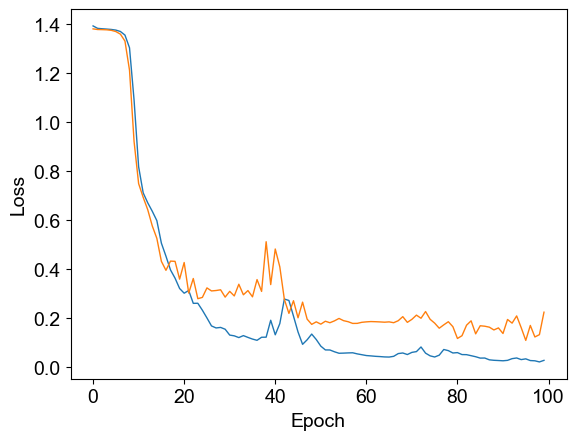

In [113]:
plt.plot(train_losses)
plt.plot(test_losses)
plt.ylabel('Loss')
plt.xlabel('Epoch')

Text(0.5, 0, 'Epoch')

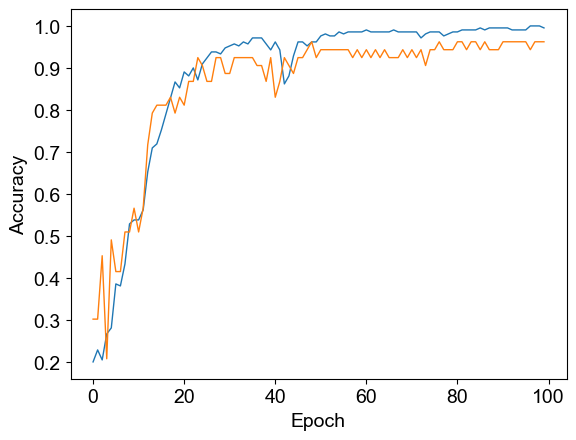

In [114]:
plt.plot(train_accuracies)
plt.plot(test_accuracies)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

In [115]:
print("Model's state_dict: ")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict: 
channel_weights.weight 	 torch.Size([4, 8])
channel_weights.bias 	 torch.Size([4])
seq_reduction_conv.weight 	 torch.Size([4, 4, 100])
seq_reduction_conv.bias 	 torch.Size([4])
gru.weight_ih_l0 	 torch.Size([384, 4])
gru.weight_hh_l0 	 torch.Size([384, 128])
gru.bias_ih_l0 	 torch.Size([384])
gru.bias_hh_l0 	 torch.Size([384])
fc.weight 	 torch.Size([4, 128])
fc.bias 	 torch.Size([4])
Optimizer's state_dict:
state 	 {0: {'step': tensor(700.), 'exp_avg': tensor([[-0.0777,  0.0029, -0.0547, -0.0052,  0.0500,  0.0251,  0.0361,  0.0085],
        [ 0.0750,  0.0011,  0.0332,  0.0008, -0.0416, -0.0114, -0.0333, -0.0054],
        [ 0.0094,  0.0030,  0.0039,  0.0024, -0.0046, -0.0020, -0.0021,  0.0006],
        [-0.0285, -0.0029, -0.0183, -0.0023,  0.0173,  0.0060,  0.0131,  0.0036]],
       device='cuda:0'), 'exp_avg_sq': tensor([[1.7663e-01, 2.3770e-02, 6.5386e-02, 1.8575e-02, 2.1063e-01, 4.5577e-02,
         3.8152e-02, 2.0491e-01],
        [1.3770e-01, 9.5280e-03, 5.649

In [93]:
torch.save(model.state_dict(), 'model_o.pt')

___
# Visualization


In [121]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix

y_pred = []
y_true = []

model.eval()
with torch.no_grad():
    for features, labels in test_loader:
        features = features.to(device).float()
        labels = labels.to(device)
        outputs = model(features)
        # print(outputs)
        outputs = torch.argmax(outputs, dim=1).cpu().numpy()

        y_pred.extend(outputs)
        y_true.extend(labels.cpu().numpy())

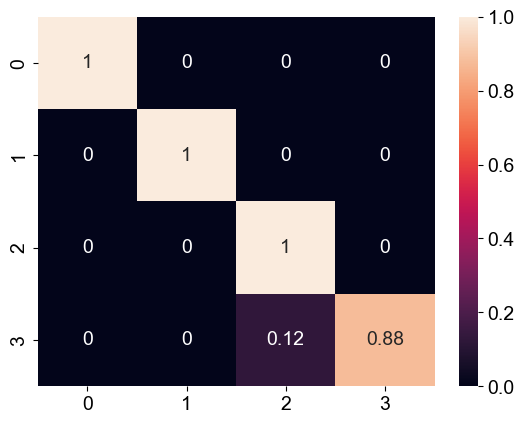

In [122]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm / np.sum(cm, axis=1), annot=True)
plt.show()